# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Libraries](#libraries)
2. [Load data](#load-data)
3. [Dataset overview](#dataset-overview)
4. [Data format conversion](#data-format-conversion)
5. [Dataset overview (single rider)](#possible-biases)
6. [Preprocessing](#preprocessing)


## 1. Libraries
Install and load necessary libraries.

In [ ]:
#Install necessary files
!pip install gpxpy
!pip install tcxreader

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpxpy
import gpxpy.gpx
import tcxreader
import tcxreader.tcxreader
import openpyxl
import os
import shutil


## 2. Load data
Load whole dataset containing all tracks of 9 riders.

In [3]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Or upload local dataset
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip /content/drive/MyDrive/opencampus_all_files/Sport1.zip -d /content

## 3. Dataset Overview
Basic exploration of the entire dataset.

In [5]:
# Load gpx.
gpx_path = '/content/Sport/Rider1/f1.gpx'
with open(gpx_path) as f:
    gpx = gpxpy.parse(f)

# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())



Number of samples: 5994
Number of features: 4
Example data:
                       time   latitude  longitude  elevation
0 2013-07-13 06:41:38+00:00  46.363649  14.112036      511.5
1 2013-07-13 06:41:39+00:00  46.363691  14.112026      511.0
2 2013-07-13 06:41:41+00:00  46.363778  14.112031      510.1
3 2013-07-13 06:41:43+00:00  46.363835  14.112023      509.7
4 2013-07-13 06:41:45+00:00  46.363888  14.112007      509.4


In [6]:
# Path to the main folder containing Rider folders
main_path = '/content/Sport'

# Iterate through each Rider folder and count the number of .gpx files
for rider_folder in sorted(os.listdir(main_path)):
    folder_path = os.path.join(main_path, rider_folder)
    if os.path.isdir(folder_path):
        gpx_files = [f for f in os.listdir(folder_path) if f.endswith('.gpx')]
        tcx_files = [f for f in os.listdir(folder_path) if f.endswith('.tcx')]
        print(f"Folder '{rider_folder}' contains {len(gpx_files)} .gpx files and {len(tcx_files)} .tcx files.")


Folder 'Rider1' contains 751 .gpx files and 0 .tcx files.
Folder 'Rider2' contains 389 .gpx files and 0 .tcx files.
Folder 'Rider3' contains 661 .gpx files and 0 .tcx files.
Folder 'Rider4' contains 810 .gpx files and 0 .tcx files.
Folder 'Rider5' contains 636 .gpx files and 0 .tcx files.
Folder 'Rider6' contains 63 .gpx files and 0 .tcx files.
Folder 'Rider7' contains 328 .gpx files and 0 .tcx files.
Folder 'Rider8' contains 0 .gpx files and 170 .tcx files.
Folder 'Rider9' contains 0 .gpx files and 585 .tcx files.


## 4. Data format conversion
Convert GPX and TCX to XLS format. In order to correctly analyse all the data its format should be firstly unified.

In [7]:
def convert_gpx_to_excel(gpx_file_path, output_file_path):
  # Initialize a DataFrame to store data
  all_data = []

  # Parse the GPX file
  with open(gpx_file_path, 'r') as gpx_file:
      gpx = gpxpy.parse(gpx_file)

  # Extract data (latitude, longitude, elevation, time, etc.)
  for track in gpx.tracks:
      for segment in track.segments:
          for point in segment.points:
              # Convert timezone-aware datetime to timezone-naive
              naive_time = point.time.replace(tzinfo=None) if point.time else None

              all_data.append({
                  'Latitude': point.latitude,
                  'Longitude': point.longitude,
                  'Elevation': point.elevation,
                  'Time': naive_time
              })

  # Convert the data into a DataFrame
  df = pd.DataFrame(all_data)

  # Write the DataFrame to an Excel file
  df.to_excel(output_file_path, index=False)


In [8]:
# TCX to XLSX
def convert_tcx_to_excel(tcx_file_path, output_file_path):
    """
    Converts a TCX file to an Excel file with trackpoint data.

    Parameters:
    - tcx_file_path: str, path to the input TCX file
    - output_file_path: str, path to save the output Excel file
    """
    # Initialize the TCX reader
    tcx_reader = TCXReader()

    # Read the TCX file
    data: TCXExercise = tcx_reader.read(tcx_file_path)

    # List to store the trackpoint data
    trackpoint_data = []

    # Loop through all trackpoints and extract relevant information
    for trackpoint in data.trackpoints:
        trackpoint_data.append({
            'Time': trackpoint.time,
            'Latitude': trackpoint.latitude,
            'Longitude': trackpoint.longitude,
            'Elevation': trackpoint.elevation,
            'Distance': trackpoint.distance,
            'Heartrate': trackpoint.hr_value,
            'Cadence': trackpoint.cadence,
            'Speed': trackpoint.tpx_ext['Speed']
        })

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(trackpoint_data)

    # Save the DataFrame to an Excel file
    df.to_excel(output_file_path, index=False, engine='openpyxl')


In [9]:
# Define the directories
sport_dir = "/content/Sport"
sport_xlsx_dir = "/content/Sport_xlsx"

# Create Sport_xlsx directory if it doesn't exist
if not os.path.exists(sport_xlsx_dir):
    os.makedirs(sport_xlsx_dir)

# Function to convert files in a folder
def convert_files_in_folder(rider_folder):
    rider_xlsx_folder = os.path.join(sport_xlsx_dir, rider_folder)

    # Create the rider folder in Sport_xlsx directory if it doesn't exist
    if not os.path.exists(rider_xlsx_folder):
        os.makedirs(rider_xlsx_folder)

    rider_folder_path = os.path.join(sport_dir, rider_folder)

    # Process .gpx files
    gpx_files = [f for f in os.listdir(rider_folder_path) if f.endswith('.gpx')]
    for gpx_file in gpx_files:
        convert_gpx_to_excel(os.path.join(rider_folder_path, gpx_file),
                           os.path.join(rider_xlsx_folder, gpx_file.replace('.gpx', '.xlsx')))

    # Process .tcx files
    tcx_files = [f for f in os.listdir(rider_folder_path) if f.endswith('.tcx')]
    for tcx_file in tcx_files:
        convert_tcx_to_excel(os.path.join(rider_folder_path, tcx_file),
                           os.path.join(rider_xlsx_folder, tcx_file.replace('.tcx', '.xlsx')))


In [ ]:
#Riders = ['Rider1', 'Rider2', 'Rider3', 'Rider4', 'Rider5', 'Rider6', 'Rider7', 'Rider8', 'Rider9']
Riders = ['Rider4']
for rider in Riders:
  convert_files_in_folder(rider)

In [ ]:
!zip -r /content/Sport_xlsx/Rider4.zip /content/Sport_xlsx/Rider4

# 5. Dataset overview (Single rider)
Load and exploration of a single rider files after succesful conversion to xlsx format.

In [ ]:
!unzip /content/drive/MyDrive/opencampus_all_files/Rider1.zip -d /content

In [12]:
directory = '/content/content/Sport_xlsx/Rider1/'

# Initialize lists and dictionaries to store results
row_counts = []
missing_values = 0

# Loop through all files in the directory
for file in os.listdir(directory):
    if file.endswith(".xlsx"):
        file_path = os.path.join(directory, file)

        # Read the Excel file
        df = pd.read_excel(file_path)

        # Count rows and add to list
        row_counts.append(df.shape[0])

        # Count missing values
        missing_values += df.isnull().sum()

In [13]:
# Print the missing values summary
print(missing_values)

Latitude     0
Longitude    0
Elevation    0
Time         0
dtype: int64


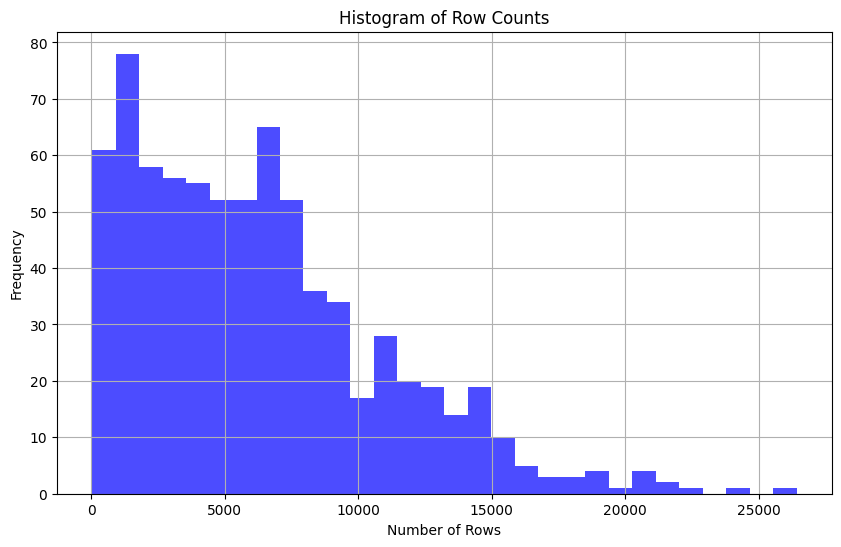

In [14]:
# Plot the histogram of row counts
plt.figure(figsize=(10, 6))
plt.hist(row_counts, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Row Counts")
plt.xlabel("Number of Rows")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

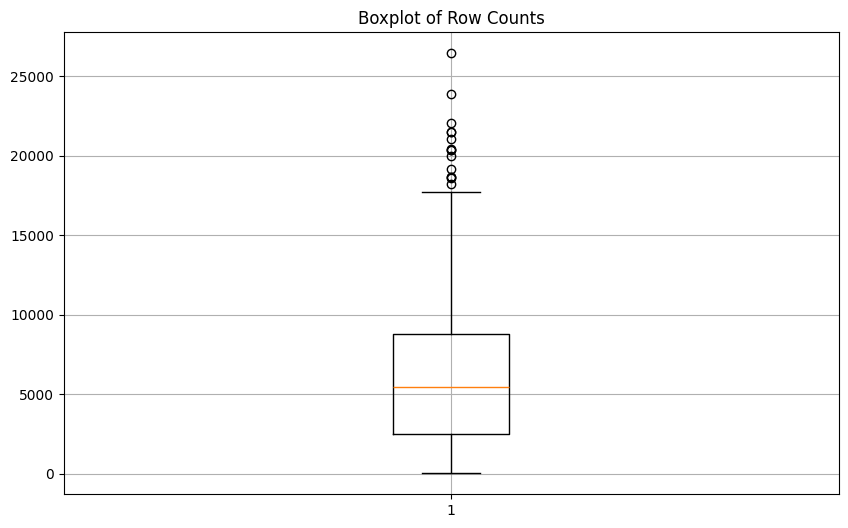

In [15]:
# Plot the boxplot of row counts
plt.figure(figsize=(10, 6))
plt.boxplot(row_counts)
plt.title("Boxplot of Row Counts")
plt.grid(True)
plt.show()

In [32]:
print(sorted(row_counts))

[26, 27, 34, 38, 70, 79, 101, 106, 199, 206, 210, 212, 266, 274, 285, 286, 327, 334, 349, 357, 371, 374, 387, 402, 406, 429, 438, 455, 469, 473, 474, 513, 526, 550, 555, 560, 601, 603, 611, 612, 644, 650, 660, 664, 698, 749, 750, 758, 765, 767, 772, 804, 807, 808, 817, 821, 841, 843, 878, 894, 898, 910, 913, 919, 933, 942, 949, 952, 990, 995, 1004, 1026, 1046, 1057, 1058, 1064, 1066, 1072, 1101, 1138, 1169, 1175, 1180, 1187, 1198, 1201, 1209, 1232, 1274, 1276, 1286, 1302, 1302, 1318, 1321, 1331, 1338, 1339, 1360, 1363, 1380, 1381, 1391, 1394, 1404, 1423, 1424, 1424, 1428, 1431, 1431, 1437, 1476, 1483, 1498, 1502, 1512, 1519, 1524, 1542, 1549, 1549, 1586, 1619, 1623, 1644, 1660, 1665, 1673, 1682, 1685, 1689, 1694, 1726, 1729, 1733, 1747, 1772, 1775, 1797, 1800, 1813, 1824, 1833, 1836, 1846, 1852, 1877, 1894, 1917, 1927, 1944, 1961, 1979, 2013, 2026, 2037, 2038, 2047, 2052, 2057, 2064, 2099, 2099, 2104, 2187, 2189, 2200, 2201, 2202, 2226, 2240, 2253, 2265, 2268, 2272, 2275, 2300, 2300, 2

In [38]:
print(sum(row_counts))

4699887


In [17]:
directory = '/content/content/Sport_xlsx/Rider1/'

# Initialize lists to store results
total_seconds = []
file_names = []

# Loop through all files in the directory
for file in os.listdir(directory):
    if file.endswith(".xlsx"):
        file_path = os.path.join(directory, file)

        # Read the Excel file
        df = pd.read_excel(file_path)

        # Convert timestamps to absolute value
        df['Time'] = pd.to_datetime(df['Time'])
        df['Time'] = (df['Time'] - df['Time'][0]).dt.total_seconds()

        # Count length of each file
        total_seconds.append(df['Time'].iloc[-1])
        file_names.append(file)  # Store the filename

# Create a DataFrame for analysis
results_df = pd.DataFrame({'File': file_names, 'TrackLength': total_seconds})

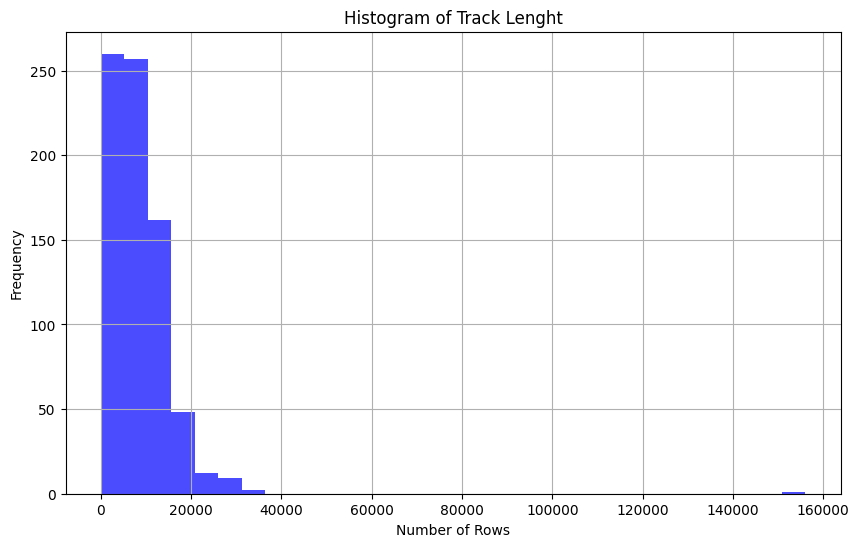

In [18]:
# Plot the histogram of file lengths
plt.figure(figsize=(10, 6))
plt.hist(total_seconds, bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Track Lenght")
plt.xlabel("Number of Rows")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

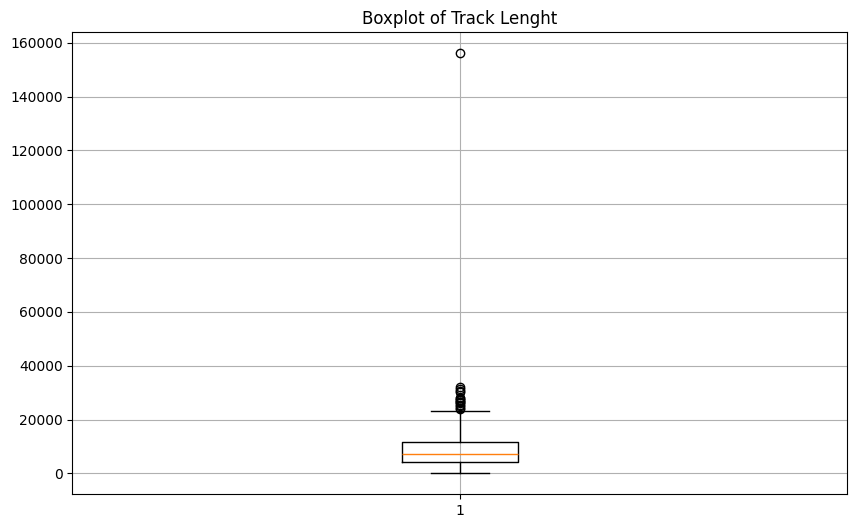

In [19]:
# Plot the boxplot of file lenghts
plt.figure(figsize=(10, 6))
plt.boxplot(total_seconds)
plt.title("Boxplot of Track Lenght")
plt.grid(True)
plt.show()

In [33]:
print(sorted(total_seconds))

[27.0, 42.0, 108.0, 135.0, 195.0, 213.0, 282.0, 382.0, 408.0, 445.0, 458.0, 475.0, 518.0, 576.0, 586.0, 623.0, 661.0, 674.0, 697.0, 716.0, 766.0, 820.0, 857.0, 881.0, 927.0, 954.0, 1020.0, 1034.0, 1072.0, 1088.0, 1101.0, 1160.0, 1188.0, 1199.0, 1210.0, 1230.0, 1231.0, 1257.0, 1274.0, 1284.0, 1327.0, 1365.0, 1367.0, 1393.0, 1400.0, 1417.0, 1432.0, 1435.0, 1441.0, 1447.0, 1451.0, 1451.0, 1457.0, 1481.0, 1508.0, 1511.0, 1514.0, 1519.0, 1523.0, 1525.0, 1527.0, 1559.0, 1559.0, 1620.0, 1628.0, 1649.0, 1652.0, 1665.0, 1701.0, 1768.0, 1773.0, 1806.0, 1807.0, 1833.0, 1837.0, 1919.0, 1939.0, 1947.0, 1953.0, 1980.0, 1983.0, 2020.0, 2020.0, 2038.0, 2054.0, 2057.0, 2063.0, 2120.0, 2127.0, 2142.0, 2182.0, 2193.0, 2205.0, 2246.0, 2280.0, 2302.0, 2304.0, 2320.0, 2335.0, 2378.0, 2384.0, 2391.0, 2534.0, 2546.0, 2559.0, 2567.0, 2569.0, 2599.0, 2612.0, 2621.0, 2653.0, 2662.0, 2675.0, 2701.0, 2705.0, 2726.0, 2734.0, 2760.0, 2763.0, 2820.0, 2821.0, 2840.0, 2844.0, 2847.0, 2851.0, 2874.0, 2887.0, 2895.0, 292

In [21]:
# Find the file with the outlier
outlier_value = results_df['TrackLength'].max()  # Assuming the outlier is the maximum value
outlier_file = results_df[results_df['TrackLength'] == outlier_value]
print("Outlier file(s):")
print(outlier_file)

Outlier file(s):
         File  TrackLength
455  f97.xlsx     156069.0


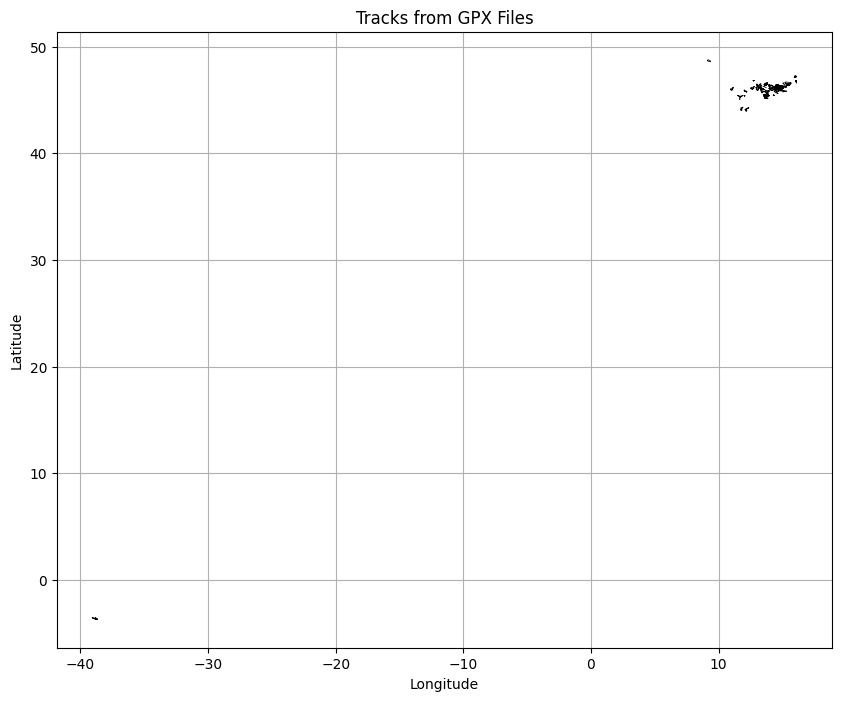

In [22]:
# Define the folder path
folder_path = '/content/Sport/Rider1/'

# Collect all GPX files in the folder
gpx_files = [file for file in os.listdir(folder_path) if file.endswith('.gpx')]

# Prepare a list for storing all tracks
all_tracks = []

# Parse each GPX file and extract track data
for gpx_file in gpx_files:
    file_path = os.path.join(folder_path, gpx_file)
    with open(file_path, 'r') as f:
        gpx = gpxpy.parse(f)
        for track in gpx.tracks:
            for segment in track.segments:
                latitudes = [point.latitude for point in segment.points]
                longitudes = [point.longitude for point in segment.points]
                all_tracks.append((latitudes, longitudes))

# Plot the tracks
plt.figure(figsize=(10, 8))
for latitudes, longitudes in all_tracks:
    plt.plot(longitudes, latitudes, color='black', linewidth=0.5)

plt.title("Tracks from GPX Files")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [23]:
def find_tracks_with_low_coords(folder_path, max_longitude=10, max_latitude=40):
    """
    Identifies GPX files with tracks extending below the specified longitude or latitude.

    Parameters:
        folder_path (str): Path to the folder containing GPX files.
        max_longitude (float): Longitude threshold to check (files with points below this are flagged).
        max_latitude (float): Latitude threshold to check (files with points below this are flagged).

    Returns:
        List of filenames matching the criteria.
    """
    flagged_files = []

    # Loop through all GPX files in the folder
    for gpx_file in os.listdir(folder_path):
        if gpx_file.endswith('.gpx'):
            file_path = os.path.join(folder_path, gpx_file)
            with open(file_path, 'r') as f:
                try:
                    gpx = gpxpy.parse(f)

                    # Check all track points
                    for track in gpx.tracks:
                        for segment in track.segments:
                            for point in segment.points:
                                if point.longitude < max_longitude or point.latitude < max_latitude:
                                    flagged_files.append(gpx_file)
                                    raise StopIteration  # Exit nested loops early
                except StopIteration:
                    continue  # Move to the next file
                except Exception as e:
                    print(f"Error processing {gpx_file}: {e}")

    return flagged_files

# Example usage
folder_path = '/content/Sport/Rider1/'
files_with_low_coords = find_tracks_with_low_coords(folder_path)

print("Files with tracks extending below 10 Longitude or 40 Latitude:")
for file in files_with_low_coords:
    print(file)

Files with tracks extending below 10 Longitude or 40 Latitude:
f377.gpx
f371.gpx
f321.gpx
f433.gpx
f344.gpx
f458.gpx
f661.gpx
f176.gpx
f125.gpx
f460.gpx
f138.gpx
f392.gpx
f480.gpx
f118.gpx
f611.gpx
f626.gpx
f296.gpx
f561.gpx
f245.gpx


In [36]:
# Parse the GPX file
file_path = '/content/Sport/Rider1/f1.gpx'
df = pd.read_excel(file_path)
df.head()

,Latitude,Longitude,Elevation,Time
0,-3.621962,-38.741665,18.2,2014-02-13 10:19:10
1,-3.621783,-38.742049,18.2,2014-02-13 10:19:20
2,-3.621696,-38.742256,18.2,2014-02-13 10:19:25
3,-3.621589,-38.742557,18.2,2014-02-13 10:19:32
4,-3.621468,-38.742913,18.2,2014-02-13 10:19:40


### 6. Preprocessing
Necessary steps before training model on the data:
- Delete files recorded outside Slovenia
- Repair corrupted file (f97)
- Convert timestamp to seconds

Optional feature engineering:
- Calculate distance since beginning


In [ ]:
# Preprocessing pipeline
import pandas as pd
import os
from geopy.distance import geodesic
from pyproj import Transformer

def preprocess_rider_data(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        if filename.endswith(".xlsx"):
            filepath = os.path.join(input_dir, filename)
            try:
                df = pd.read_excel(filepath)

                # Step 1: If file is f97.xlsx, delete the first 11 rows
                if filename == "f97.xlsx":
                    df = df.iloc[11:].reset_index(drop=True)

                # Step 2: Delete the file if max_longitude < 10 or max_latitude < 40
                if df['Longitude'].max() < 10 or df['Latitude'].max() < 40:
                    print(f"File {filename} deleted due to coordinates.")
                    os.remove(filepath)
                    continue  # Skip the rest of the loop for this file

                # Step 3: Convert timestamp to seconds
                df['Time'] = pd.to_datetime(df['Time'])
                df['Time'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()

                # Step 4: Calculate distance since the beginning
                distances = []
                cumulative_distance = 0
                for i in range(len(df)):
                    if i > 0:
                        previous_coords = (df['Latitude'].iloc[i-1], df['Longitude'].iloc[i-1])
                        current_coords = (df['Latitude'].iloc[i], df['Longitude'].iloc[i])
                        distance = geodesic(previous_coords, current_coords).meters
                        cumulative_distance += distance
                    else:
                        distance = 0
                    distances.append(cumulative_distance)
                df['Distance'] = distances

                # Step 5: Save the preprocessed file
                output_filepath = os.path.join(output_dir, filename)
                df.to_excel(output_filepath, index=False)
                print(f"Processed and saved: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")


# Example usage (replace with your actual paths):
input_directory = '/content/content/Sport_xlsx/Rider1/'
output_directory = '/content/content/Sport_xlsx/Rider1_preprocessed/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

preprocess_rider_data(input_directory, output_directory)

In [ ]:
!zip -r /content/content/Sport_xlsx/Rider1_preprocessed.zip /content/content/Sport_xlsx/Rider1_preprocessed